In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import sklearn.linear_model as lm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

In [164]:
path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

In [165]:
iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

In [166]:
iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'cluster', 'sids', 'pseudoMRNs'])

In [167]:
iic_burden['Yname']

'DC MRS (modified ranking scale)'

In [168]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

In [339]:
def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in tqdm.tqdm(range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

In [340]:
frame = 25
df = setup_data(iic_burden,frame=frame)

100%|██████████| 1323/1323 [00:11<00:00, 116.59it/s]


In [341]:
print(list(df.columns))

['Gender', 'Age', 'marrital', 'APACHE II  first 24', 'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF', 'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)', 'Hx CNS cancer', 'Hx COPD/ Asthma', 'premorbid MRS before admission  (modified ranking scale),before admission', 'SZ at presentation,(exclude non-convulsive seizures) just if it is mentioned in MGH notes (the date is necessary, however,the date is the day of admission at MGH)', 'hydrocephalus  (either on admission or during hospital course)   QPID', 'iMV  (initial (on admission) mechanical ventilation)', 'systolic BP', 'diastolic BP', 'Midline shift with any reason ( Document Date)', 'Primary systemic dx Sepsis/Shock', 'iGCS-Total', 'iGCS = T?', 'iGCS-E', 'iGCS-V', 'iGCS-M', 'Worst GCS in 1st 24', 'Worst GCS 

<AxesSubplot:xlabel='Age', ylabel='time_of_intervention'>

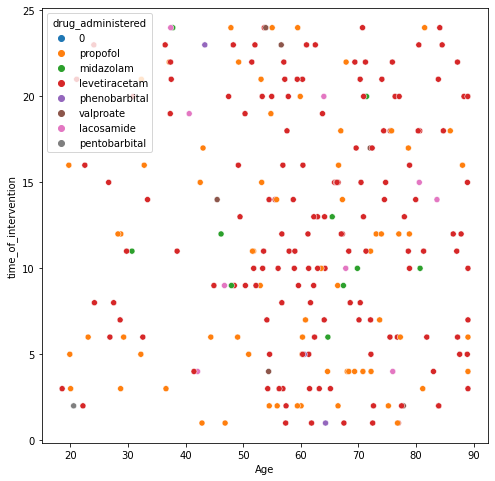

In [342]:
plt.figure(figsize=(8,8))
sns.scatterplot(y='time_of_intervention',x='Age',hue='drug_administered',data=df.loc[df['time_of_intervention']>0])

In [343]:
short_term_df = df.loc[df['time_of_intervention']>0][['Gender', 'Age', 'marrital', 
                                                 'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                                                 'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF', 'Hx DM', 'Hx of HLD', 
                                                 'Hx tobacco (including ex-smokers)', 
                                                 'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                                                 'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)', 
                                                 'Hx CNS cancer', 'Hx COPD/ Asthma', 'premorbid MRS before admission  (modified ranking scale),before admission', 
                                                 'SZ at presentation,(exclude non-convulsive seizures) just if it is mentioned in MGH notes (the date is necessary, however,the date is the day of admission at MGH)',
                                                 'hydrocephalus  (either on admission or during hospital course)   QPID', 'iMV  (initial (on admission) mechanical ventilation)', 
                                                 'systolic BP', 'diastolic BP', 'Midline shift with any reason ( Document Date)', 'Primary systemic dx Sepsis/Shock', 
                                                 'iGCS-Total', 'iGCS = T?', 'iGCS-E', 'iGCS-V', 'iGCS-M', 'Worst GCS in 1st 24', 'Worst GCS Intubation status', 
                                                 'iGCS actual scores', 'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders', 
                                                 'time_of_intervention', 'drug_administered']+['iic_%d'%(i) for i in range(frame)]]


1. For each time of intervention
2. For each drug


Calculate the drug effect

In [346]:
def synthetic_control(units_ts,
                      treatments,
                      time_of_intervention,
                      effect_dict,
                      method='Lasso'):
    
    donors = units_ts.loc[treatments==0].drop(columns=['time_of_intervention'])
    targets = units_ts.loc[units_ts['time_of_intervention']==time_of_intervention].drop(columns=['time_of_intervention'])
    for idx in tqdm.tqdm(targets.index):
        y = targets.loc[idx]
        ypre = y[:time_of_intervention]
        if method=='Lasso':
            model = lm.LassoCV()
        if method=='Ridge':
            model = lm.RidgeCV()
        if method=='RF':
            model = en.RandomForestRegressor()
        if method=='Linear':
            model = lm.LinearRegression()
        model = model.fit(donors.to_numpy()[:,:time_of_intervention].T,ypre)
        y_hat = model.predict(donors.T.to_numpy())
        effect = pd.DataFrame([y.to_numpy().reshape(-1,) - y_hat.reshape(-1,)],
                              index=[idx],
                              columns=10*np.arange(-time_of_intervention+2,frame-time_of_intervention+2))
        effect_dict[treatments.loc[idx]] = effect_dict[treatments.loc[idx]].append(effect)
    return effect_dict

In [347]:
units_ts = short_term_df[['time_of_intervention']+['iic_%d'%(i) for i in range(frame)]].fillna(method='bfill').fillna(method='ffill').fillna(0)
treatments = short_term_df['drug_administered']
effect_dict = {treatment:pd.DataFrame() for treatment in treatments.unique()}
for time_of_intervention in range(10,20):
    effect_dict = synthetic_control(units_ts,treatments,time_of_intervention,effect_dict,method='Ridge')
    

100%|██████████| 5/5 [00:00<00:00, 282.84it/s]


<AxesSubplot:>

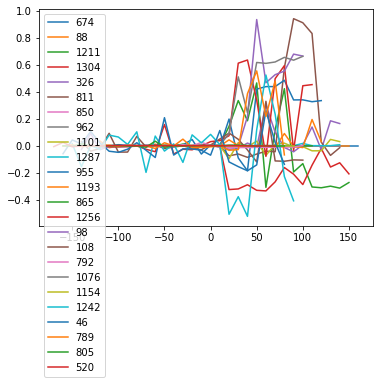

In [350]:
effect_dict['propofol'].T.plot(kind='line')

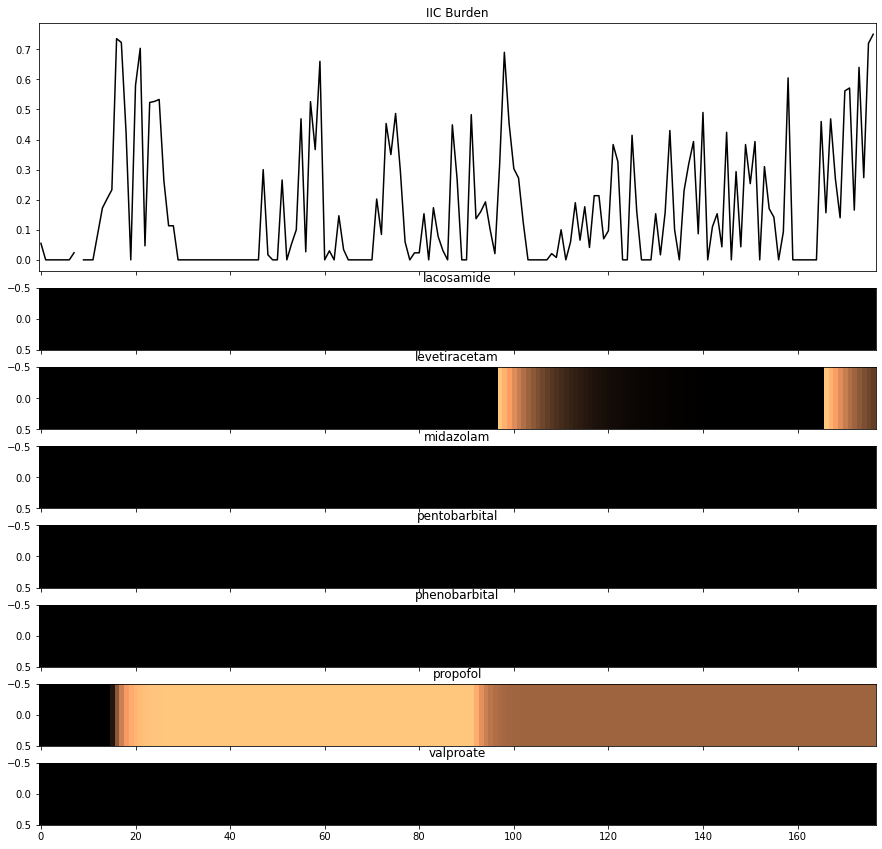

In [359]:
E = iic_burden['Pobs'][1256]
D = iic_burden['D'][1256]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

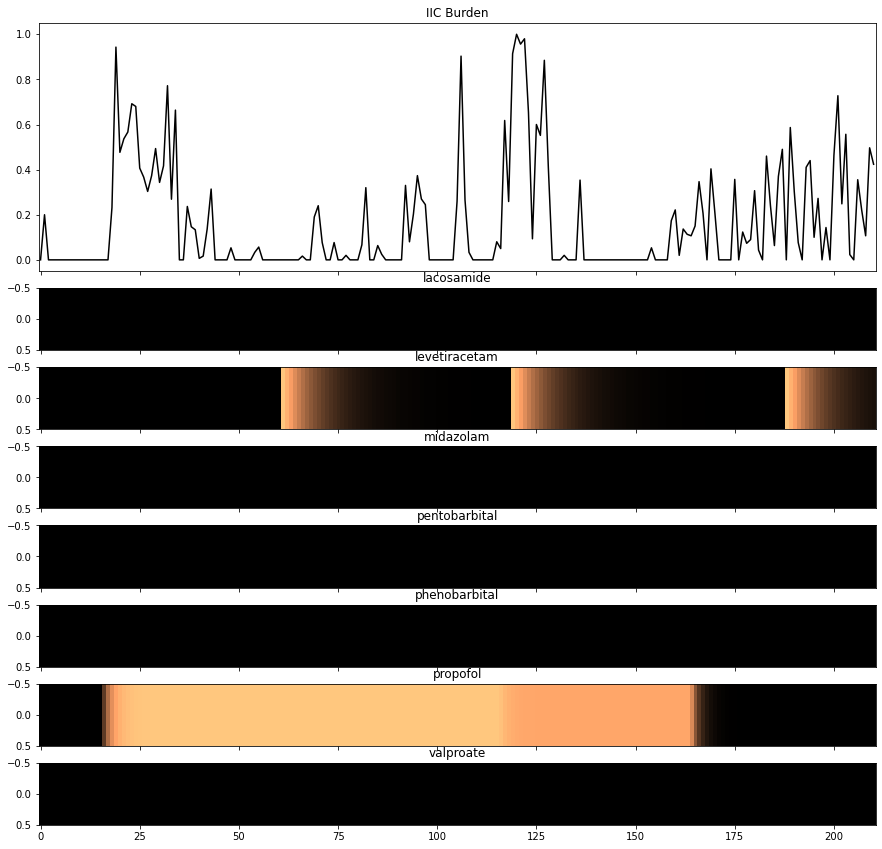

In [355]:
E = iic_burden['Pobs'][98]
D = iic_burden['D'][98]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

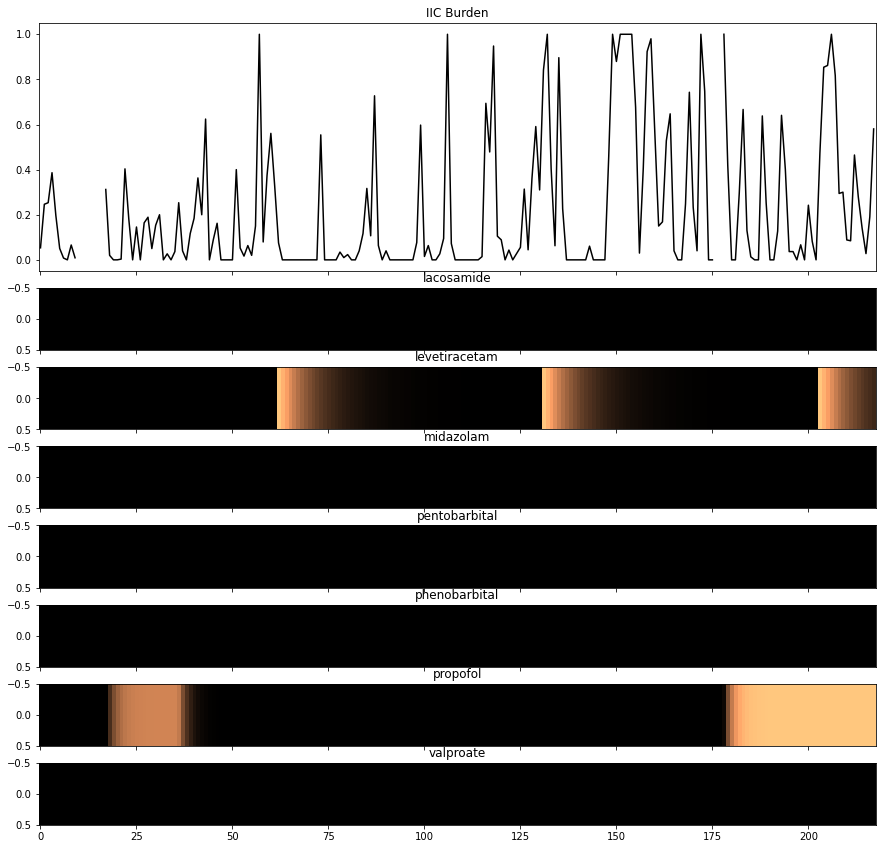

In [353]:
E = iic_burden['Pobs'][955]
D = iic_burden['D'][955]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

<AxesSubplot:>

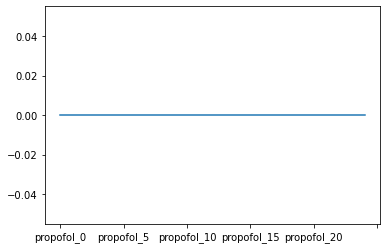

In [345]:
df.index[673]
df[['propofol_%d'%(i) for i in range(0,25)]].loc[673].plot(kind='line')

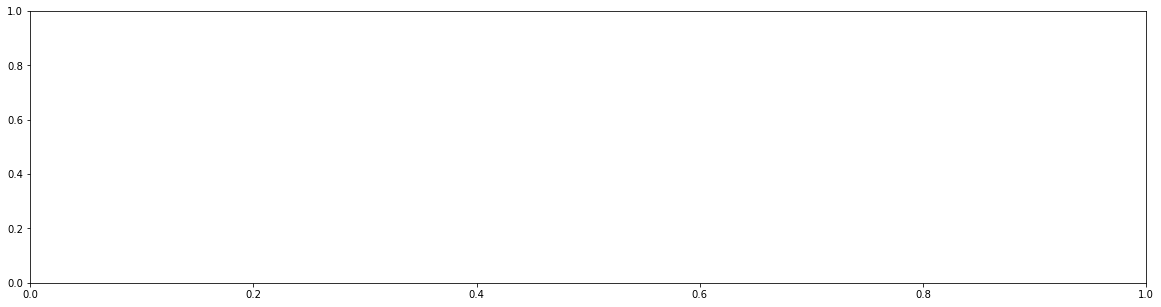

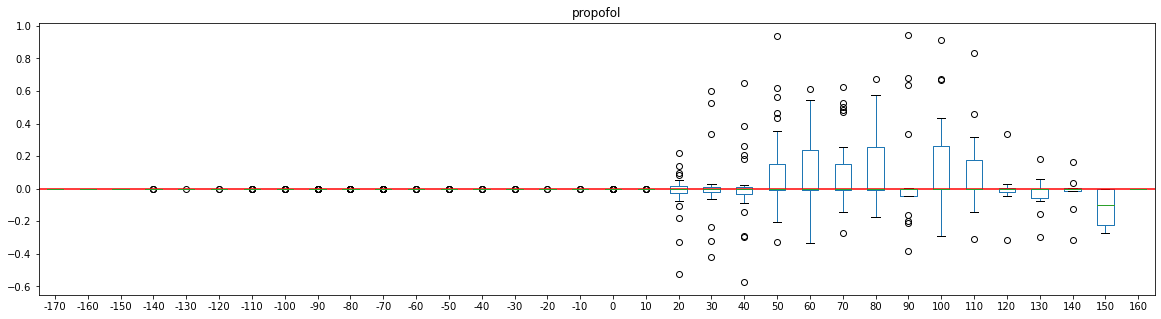

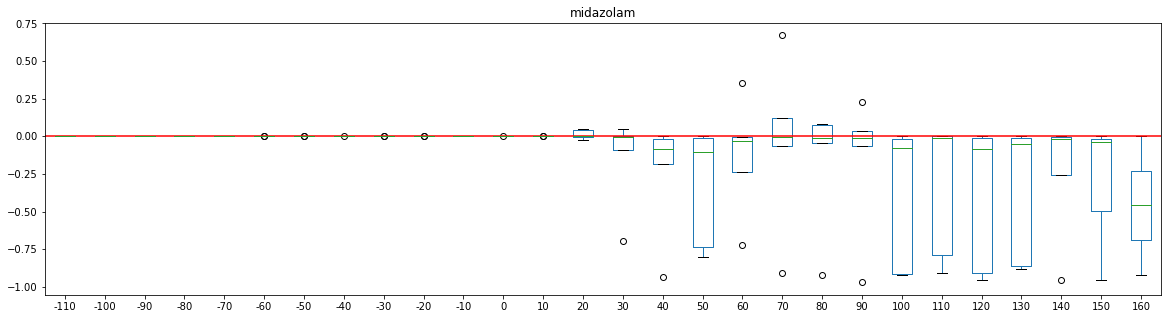

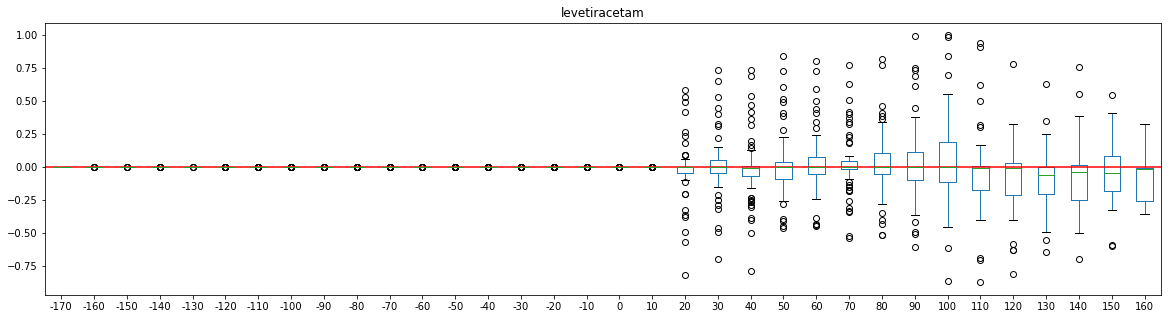

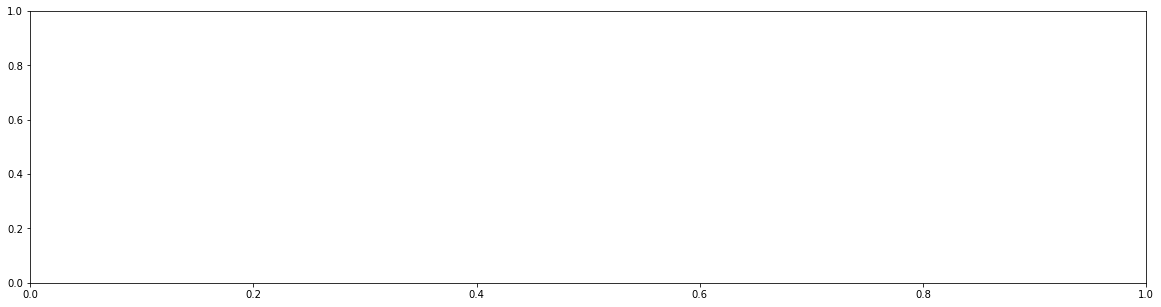

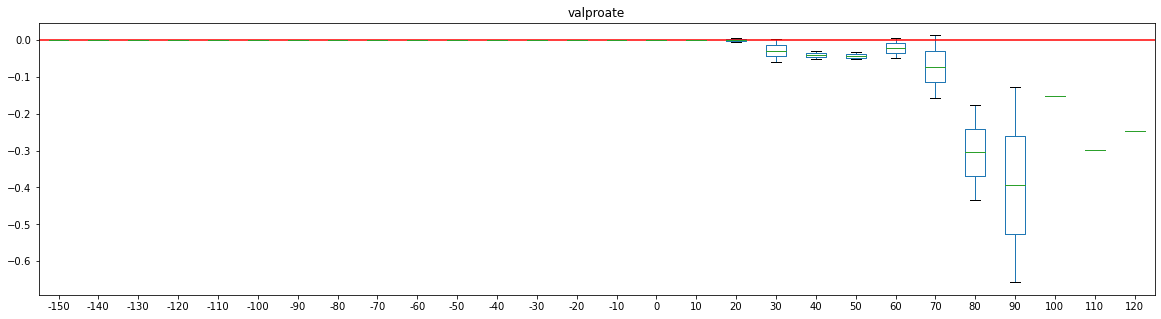

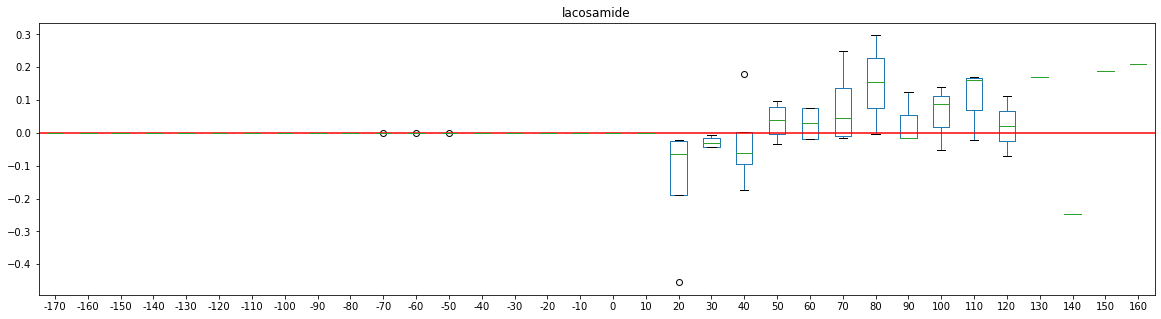

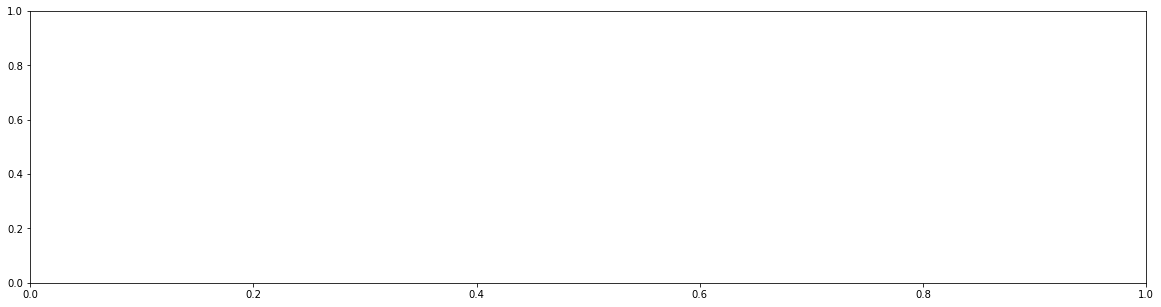

In [325]:
for treatment in treatments.unique():
    fig,ax = plt.subplots(figsize=(20,5))
    try:
        effect_dict[treatment].plot(kind='box',ax=ax)
    except:
        continue
#     plt.axvline(0,color='red')
    plt.axhline(0,color='red')
    plt.title(treatment)